###Setup

Instalandos os pacotes necessários.

### Inserindo as variáveis de ambiente.

In [40]:

import os



os.environ['OPENAI_API_KEY'] = "OPENAI_API_KEY"
os.environ['TAVILY_API_KEY'] = "TAVILY_API_KEY"

### Criando Agentes

As funções a seguir irão auxiliar na criação de agentes. Os agentes serão nós no graph.

In [59]:
from langchain_core.messages import (BaseMessage, HumanMessage, ToolMessage,)
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

def create_agent(llm,tools,system_message:str):
  "Criando um agente"
  prompt = ChatPromptTemplate.from_messages(
      [
          ("system",
           "Você é um assistente de IA, colaborando com outros assistente."
           "Use as ferramentas fornecidas para avançar na resposta á pergunta."
           "Se você não conseguir responder totalmente, tudo bem, outro assistente com ferramentas diferentes, ajudará de onde você parou. Execute o que puder para progredir. Se voce ou algum dos outros assistante tiver a resposta final, prefixe a sua resposta com RESPOSTA FINAL para que a equipe saiba que deve parar."
           "Você tem acesso as seguintes ferramentas: {tool_names}.\n"
           "{system_message}",
          ),
          MessagesPlaceholder(variable_name="messages")
      ]
    )
  prompt = prompt.partial(system_message=system_message)
  prompt = prompt.partial(tool_names =", ".join([tool.name for tool in tools]))
  return prompt | llm.bind_tools(tools)

### Criando as Ferramentas

Essas ferramentas serão utilizadas posteriomente pelos agentes.

In [58]:
from typing import Annotated
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

tavily = TavilySearchResults(max_results=5)
repl = PythonREPL()


###Essa tool irá crirar um código em Python, que posteriormente será consumido para gerar um gráfico.
@tool
def python_repl(code: Annotated[str, "The python code to execute to generate your chart."],):
  """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""

  try:
    result = repl.run(code)
  except BaseException as e:
    return f"Falha ao executar {repr(e)}"
  result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"

  return (result_str + "\n\n\n Se você tiver completado todas as tarefas, responda com RESPOSTA FINAL")


### Inicializando a criação do Graph

Agora vamos criar os agente individuais e dizer a eles como interagirem entre si utilizando o LangGraph.

#### Definindo o State

O primeiro passo é definir o state do graph. Este será apenas uma lista de mensagens, juntamente com uma chave para rastrear o envio mais recente.

In [60]:
import operator
from typing import Annotated, Sequence
from typing_extensions import TypedDict

class AgentState(TypedDict):
  messages: Annotated[Sequence[BaseMessage], operator.add]
  sender: str

### Definindo Agent Nodes

Agora, vamos iniciar a definir os nós, mas primeiro vamos definir os nós dos agentes.

In [61]:
import functools
from langchain_core.messages import AIMessage
from langchain_openai import ChatOpenAI

##Função auxiliar, que irá ajudar a criar um nó para um determinado agente
def agent_node(state,agent,name):
  result = agent.invoke(state)

  if isinstance(result,ToolMessage):
    pass
    ### Aqui excluimos o tipo e nome da mensagem anterior, para atualizar ela com o nome correto.
  else:
    result = AIMessage(**result.dict(exclude={"type","name"}), name=name)

  return {
      "messages": [result],
      "sender": name
  }

llm = ChatOpenAI(model="gpt-4o-mini")

research_agent = create_agent(
    llm,
    [tavily],
    system_message = "You should provide accurate data for the chart_generator to use."
)

research_node = functools.partial(agent_node, agent=research_agent, name = "Researcher")

chart_agent = create_agent(
    llm,
    [python_repl],
    system_message = "Any charts you display will be visible by the user."
)

chart_node = functools.partial(agent_node, agent=chart_agent, name = "chart_generator")

### Definindo Tool Node

Agora vamos definir o nó que irá rodar as feramentas.

In [62]:
from langgraph.prebuilt import ToolNode

tools = [tavily,python_repl]
tool_node = ToolNode(tools)

### Definindo a Lógica do Edge

Vamos definir a parte lógica do edge necessário para decidir o que fazer, com base no resultado dos agentes.

In [63]:
from typing import Literal
from langgraph.graph import END, StateGraph, START

def router(state):
  messages = state["messages"]
  last_message = messages[-1]

  if last_message.tool_calls:
    return "call_tool"
  if "RESPOSTA FINAL" in last_message.content:
    return END
  return "continue"

### Definindo o Graph

In [68]:
workflow = StateGraph(AgentState)

workflow.add_node("Researcher", research_node)
workflow.add_node("chart_generator", chart_node)
workflow.add_node("call_tool", tool_node)

## Criando a condicional, que se ele seguir, derá ir para 'chart_generator'.
## Se ele chamar uma ferramenta, irá para 'call_tool'
## Se ele encerrar, irá chamar o END e encerrar o workflow.
workflow.add_conditional_edges(
    "Researcher",
    router,
    {"continue":"chart_generator","call_tool":"call_tool", END:"chart_generator"}
)

## Criando a condicional, que se ele seguir, derá ir para 'Researcher'.
## Se ele chamar uma ferramenta, irá para 'call_tool'
## Se ele encerrar, irá chamar o END e encerrar o workflow.
workflow.add_conditional_edges(
    "chart_generator",
    router,
    {"continue":"Researcher","call_tool":"call_tool", END:END}
)

## Criando a condicional, que ele irá verificar no 'sender'.
## Para ver quem lhe enviou ao 'call_tools'
## E retornar o fluxo para o agente que enviou ele para cá
workflow.add_conditional_edges(
    "call_tool",
    lambda x: x["sender"],
    {
    "Researcher":"Researcher",
    "chart_generator":"chart_generator",
    },
)
workflow.add_edge(START,"Researcher")
graph = workflow.compile()

### Verificando imagem de como ficou o Graph.

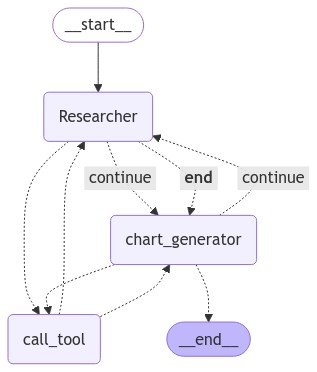

In [69]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

## Chamando o Graph

Vamos agora testar o graph, invokando ele e analisando como está sendo os passos do agente.

{'Researcher': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_I1xABHoLrhh5Orj373ynuuDQ', 'function': {'arguments': '{"query":"PIB do Brasil últimos 5 anos"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 223, 'total_tokens': 248, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_e2bde53e6e', 'finish_reason': 'tool_calls', 'logprobs': None}, name='Researcher', id='run-eb058ec3-00de-401f-94bf-5546c3aaf40a-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'PIB do Brasil últimos 5 anos'}, 'id': 'call_I1xABHoLrhh5Orj373ynuuDQ', 'type': 'tool_call'}], usage_metadata={'input_tokens': 223, 'output_tokens': 25, 'total_tokens': 248, 'input_token_details': {'cache_read':

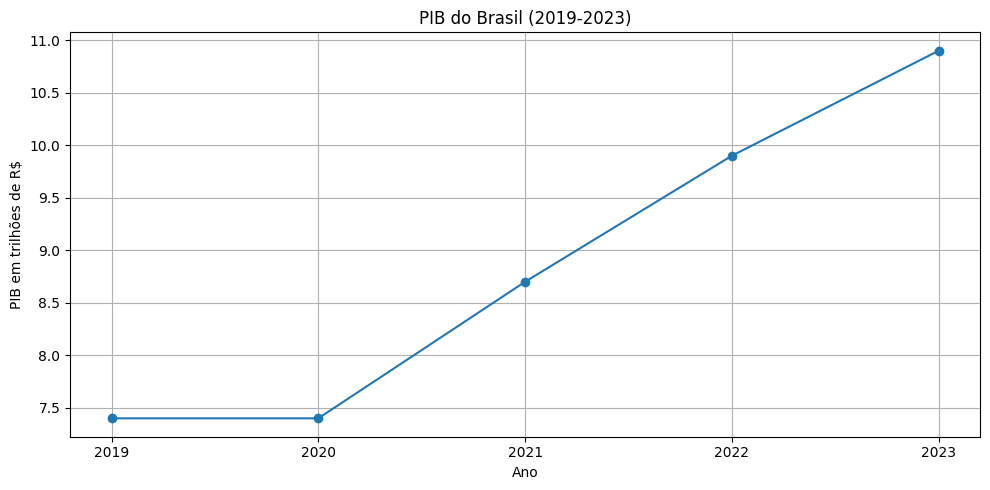

{'call_tool': {'messages': [ToolMessage(content="Successfully executed:\n\\`\\`\\`python\nimport matplotlib.pyplot as plt\n\n# Dados do PIB do Brasil nos últimos 5 anos\nanos = [2019, 2020, 2021, 2022, 2023]\nPIB = [7.4, 7.4, 8.7, 9.9, 10.9]  # em trilhões de R$\n\n# Criando o gráfico\nplt.figure(figsize=(10, 5))\nplt.plot(anos, PIB, marker='o')\nplt.title('PIB do Brasil (2019-2023)')\nplt.xlabel('Ano')\nplt.ylabel('PIB em trilhões de R$')\nplt.xticks(anos)\nplt.grid(True)\nplt.tight_layout()\n\n# Mostrando o gráfico\nplt.show()\n\\`\\`\\`\nStdout: \n\n\n Se você tiver completado todas as tarefas, responda com RESPOSTA FINAL", name='python_repl', tool_call_id='call_U98qnZqDHmY6BuXL2is4T6SV')]}}
------
{'chart_generator': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_EkP1RWlMYEpg9tcZBg7vemUc', 'function': {'arguments': '{"code":"import matplotlib.pyplot as plt\\n\\n# Dados do PIB do Brasil nos últimos 5 anos\\nanos = [2019, 2020, 2021, 2022, 2023]\\n

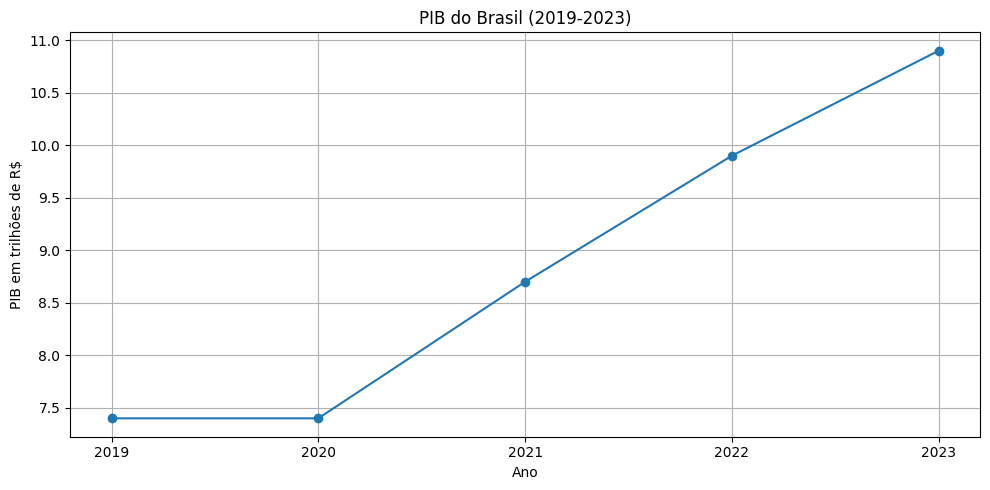

{'call_tool': {'messages': [ToolMessage(content="Successfully executed:\n\\`\\`\\`python\nimport matplotlib.pyplot as plt\n\n# Dados do PIB do Brasil nos últimos 5 anos\nanos = [2019, 2020, 2021, 2022, 2023]\nPIB = [7.4, 7.4, 8.7, 9.9, 10.9]  # em trilhões de R$\n\n# Criando o gráfico\nplt.figure(figsize=(10, 5))\nplt.plot(anos, PIB, marker='o')\nplt.title('PIB do Brasil (2019-2023)')\nplt.xlabel('Ano')\nplt.ylabel('PIB em trilhões de R$')\nplt.xticks(anos)\nplt.grid(True)\nplt.tight_layout()\n\n# Mostrando o gráfico\nplt.show()\n\\`\\`\\`\nStdout: \n\n\n Se você tiver completado todas as tarefas, responda com RESPOSTA FINAL", name='python_repl', tool_call_id='call_EkP1RWlMYEpg9tcZBg7vemUc')]}}
------
{'chart_generator': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_mtAul6GcIKYN9KnWcbCgoTZX', 'function': {'arguments': '{"code":"import matplotlib.pyplot as plt\\n\\n# Dados do PIB do Brasil nos últimos 5 anos\\nanos = [2019, 2020, 2021, 2022, 2023]\\n

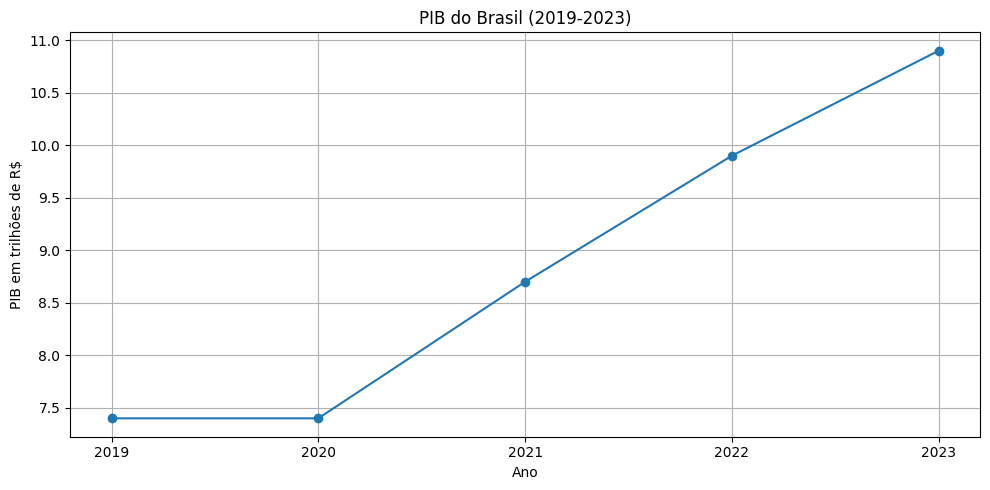

{'call_tool': {'messages': [ToolMessage(content="Successfully executed:\n\\`\\`\\`python\nimport matplotlib.pyplot as plt\n\n# Dados do PIB do Brasil nos últimos 5 anos\nanos = [2019, 2020, 2021, 2022, 2023]\nPIB = [7.4, 7.4, 8.7, 9.9, 10.9]  # em trilhões de R$\n\n# Criando o gráfico\nplt.figure(figsize=(10, 5))\nplt.plot(anos, PIB, marker='o')\nplt.title('PIB do Brasil (2019-2023)')\nplt.xlabel('Ano')\nplt.ylabel('PIB em trilhões de R$')\nplt.xticks(anos)\nplt.grid(True)\nplt.tight_layout()\n\n# Mostrando o gráfico\nplt.show()\n\\`\\`\\`\nStdout: \n\n\n Se você tiver completado todas as tarefas, responda com RESPOSTA FINAL", name='python_repl', tool_call_id='call_mtAul6GcIKYN9KnWcbCgoTZX')]}}
------
{'chart_generator': {'messages': [AIMessage(content='Aqui está o gráfico de linhas do PIB do Brasil nos últimos 5 anos:\n\n![Gráfico do PIB do Brasil (2019-2023)](attachment://pib_brasil_2019_2023.png)\n\n- **2019**: R$ 7,4 trilhões\n- **2020**: R$ 7,4 trilhões\n- **2021**: R$ 8,7 trilhõe

In [70]:
events = graph.stream(
    {
        "messages":[
            HumanMessage(
                content = "Colete o PIB do Brasil dos últimos 5 anos"
                " E gere um gráfico de linhas do PIB."
                " Ao terminar, finalize."
            )
        ],
    },
    {"recursion_limit":150},
)

for s in events:
  print(s)
  print("------")